# 读取数据

In [8]:
import json

# 读取 Combined_Personas.json，提取每个代理的 id 和 type
agent_type_map = {}
with open('./config/luban/Combined_Personas.json', 'r') as f:
    personas = json.load(f)
    # 假设 personas 要么是包含代理列表的列表，要么是包含 'agents' 键的字典
    if isinstance(personas, list):
        agents_list = personas
    elif isinstance(personas, dict):
        agents_list = personas.get('agents', personas.get('Agents', personas))
        # 若 personas 本身就是一个单个代理的信息字典，则上行直接返回 personas
        if isinstance(agents_list, dict):
            agents_list = [agents_list]
    else:
        agents_list = []
    # 提取 id 和 type
    for agent in agents_list:
        agent_id = str(agent.get('id'))
        # print(agent_id, agent.get('id'), agent.get('ID'), agent.get('Id'))

        agent_type = agent.get('type') or agent.get('Type')
        if agent_id and agent_type:
            agent_type_map[agent_id] = agent_type




In [9]:
import glob

interactions = []        # 用于存储交互边的信息
attitude_data = {}       # 用于存储每个代理随时间的态度变化
seen_events = set()      # 用于避免重复记录交互事件

# 初始化 attitude_data 字典，包含所有代理的ID键
for aid in agent_type_map.keys():
    attitude_data[aid] = {}

# 遍历所有 ./log/experiment_test1_3_17 下的 agent_*.json 文件
for file in glob.glob('./log/experiment_test1_3_19/agent_*.json'):
    # 从文件名获取 agent ID（假设文件名格式为 agent_<ID>.json）
    print(f"Processing file {file}")
    agent_id = file.split('\\')[1].split('.')[0].split('_')[1]
    with open(file, 'r', encoding='utf-8') as f:
        events = json.load(f)
    
    for event in events:
        ts = event.get('ts')
        event_type = event.get('type')
        item = event.get('item', {})
        
        # 如果存在source和attitude，则为一次交互
        src = item.get('source')
        tgt = agent_id
        att = item.get('attitude')

        # 交互记录
        if src is not None and event['type'] in ["listen", "talk_content"]:
            event_key = (ts, str(src), tgt, event['type'])
            if event_key not in seen_events:
                interactions.append({
                    'source': str(src),
                    'target': tgt,
                    'type': event['type'],
                    'attitude': att,
                    'time': ts
                })
                seen_events.add(event_key)

        # 如果是update或reflect，则记录态度变化
        if event['type'] in ['update', 'reflect', 'vote']:
            new_attitude = item.get('new_attitude') or item.get('attitude')
            if new_attitude is not None:
                print(f"Agent {agent_id} at time {ts} has attitude {new_attitude}")
                attitude_data[tgt][ts] = new_attitude

# 查看解析出的部分交互和态度数据（打印前5条交互和每个代理的初末态度）
print(f"总共提取了 {len(interactions)} 条交互记录。示例几条记录:")
for inter in interactions[:5]:
    print(inter)
print("\n各代理的初始态度和最终态度:")
for aid, times in attitude_data.items():
    if times:
        t_min, t_max = min(times), max(times)
        print(f"Agent {aid} - 初始态度(time {t_min}): {times[t_min]}, 最终态度(time {t_max}): {times[t_max]}")


Processing file ./log/experiment_test1_3_19\agent_0.json
Agent 0 at time 0 has attitude 1.1221786632568262
Agent 0 at time 1 has attitude 7.04712461178447
Agent 0 at time 1 has attitude 7.04712461178447
Agent 0 at time 2 has attitude -22.611094625649272
Agent 0 at time 2 has attitude 9.338959110218017
Agent 0 at time 3 has attitude 39.497334693502
Agent 0 at time 3 has attitude 39.497334693502
Agent 0 at time 4 has attitude -21.60524373486618
Agent 0 at time 4 has attitude -30.915151214571402
Agent 0 at time 5 has attitude -123.49849301561893
Agent 0 at time 5 has attitude -123.49849301561893
Processing file ./log/experiment_test1_3_19\agent_1.json
Agent 1 at time 1 has attitude 0.7
Agent 1 at time 3 has attitude 0.8
Agent 1 at time 5 has attitude 0.89
Processing file ./log/experiment_test1_3_19\agent_10.json
Agent 10 at time 0 has attitude 0.8502780932969389
Agent 10 at time 0 has attitude 0.8502780932969389
Agent 10 at time 1 has attitude 0.8502780932969389
Agent 10 at time 1 has att

In [10]:
# 1. 获取每个agent的最终态度
final_attitudes = {}
for aid, times in attitude_data.items():
    if times:  # 确保该agent有态度记录
        t_max = max(times)  # 找到最大时间戳
        final_attitudes[aid] = times[t_max]  # 记录最终态度

# 2. 定义态度类别函数
def get_attitude_category(attitude):
    if attitude < 0:
        return 'negative'
    elif attitude == 0:
        return 'neutral'
    else:
        return 'positive'

# 3. 初始化统计字典
type_attitude_counts = {atype: {'negative': 0, 'neutral': 0, 'positive': 0} 
                        for atype in set(agent_type_map.values())}

# 4. 统计每种agent类型在每种态度类别下的人数
for aid, attitude in final_attitudes.items():
    atype = agent_type_map.get(aid)  # 获取agent类型
    if atype:  # 确保agent类型存在
        category = get_attitude_category(attitude)  # 获取态度类别
        type_attitude_counts[atype][category] += 1  # 更新计数

# 5. 打印结果
print("最终态度的各类agent的人数统计：")
for atype, counts in type_attitude_counts.items():
    print(f"Agent 类型: {atype}")
    for category, count in counts.items():
        print(f"  {category}: {count}")

最终态度的各类agent的人数统计：
Agent 类型: lite
  negative: 46
  neutral: 0
  positive: 60
Agent 类型: full
  negative: 1
  neutral: 0
  positive: 10
Agent 类型: brief
  negative: 1
  neutral: 0
  positive: 9


# 箱线分布图


--- 每种 Agent 类型的态度均值 ---
brief 类型 Agent 的态度均值: 0.49
lite 类型 Agent 的态度均值: 0.62
full 类型 Agent 的态度均值: 0.67


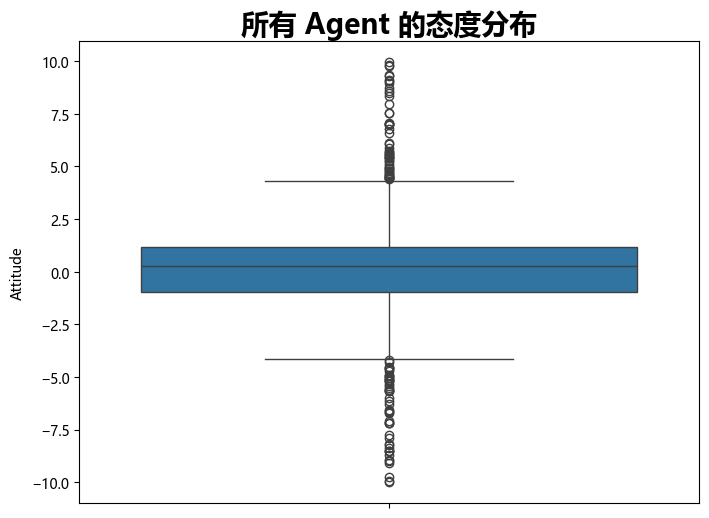

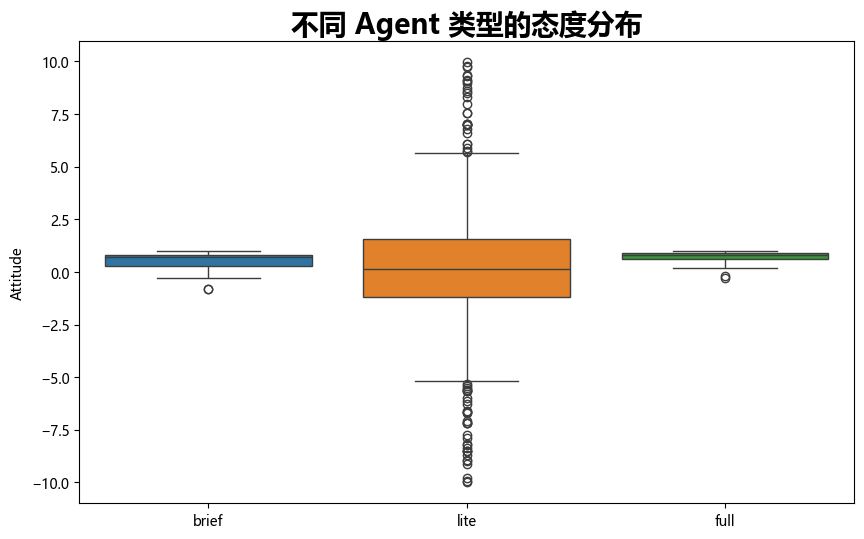

In [74]:
# --- 后续分析部分 ---
import json
import glob
import seaborn as sns
import matplotlib.pyplot as plt
### 1. 计算态度均值
# 1. 按类型分组态度数据
type_attitude_data = {atype: [] for atype in set(agent_type_map.values())}
for aid, attitudes in attitude_data.items():
    atype = agent_type_map.get(aid)
    if atype and attitudes:
        type_attitude_data[atype].extend(attitudes.values())

# 去除态度中绝对值大于10的异常值


# 2. 计算每种类型的态度均值并输出
print("\n--- 每种 Agent 类型的态度均值 ---")
for atype, attitudes in type_attitude_data.items():
    if attitudes:
        type_mean_att = sum(attitudes) / len(attitudes)
        print(f"{atype} 类型 Agent 的态度均值: {type_mean_att:.2f}")
    else:
        print(f"{atype} 类型 Agent 没有态度数据")

# 去除态度中绝对值大于10的异常值
for aid, attitudes in attitude_data.items():
    attitude_data[aid] = {t: att for t, att in attitudes.items() if abs(att) <= 10}

### 2. 绘制所有 agent 的态度箱线图
all_attitudes = [att for times in attitude_data.values() for att in times.values()]
plt.figure(figsize=(8, 6))
sns.boxplot(data=all_attitudes)
plt.title("所有 Agent 的态度分布", fontsize=20, fontweight='bold')
plt.ylabel("Attitude")
plt.savefig("优化后_all_agents_attitude_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

### 3. 按 agent 类型分析情绪分布
# 按类型分组态度数据
type_attitude_data = {atype: [] for atype in set(agent_type_map.values())}
for aid, attitudes in attitude_data.items():
    atype = agent_type_map[aid]
    type_attitude_data[atype].extend(attitudes.values())

# 绘制不同类型的箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(data=[type_attitude_data[atype] for atype in type_attitude_data])
plt.xticks(ticks=range(len(type_attitude_data)), labels=type_attitude_data.keys())
plt.title("不同 Agent 类型的态度分布", fontsize=20, fontweight='bold')
plt.ylabel("Attitude")
plt.savefig("优化后_agent_types_attitude_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


# 网络结构图

Nodes: 127, Edges: 991


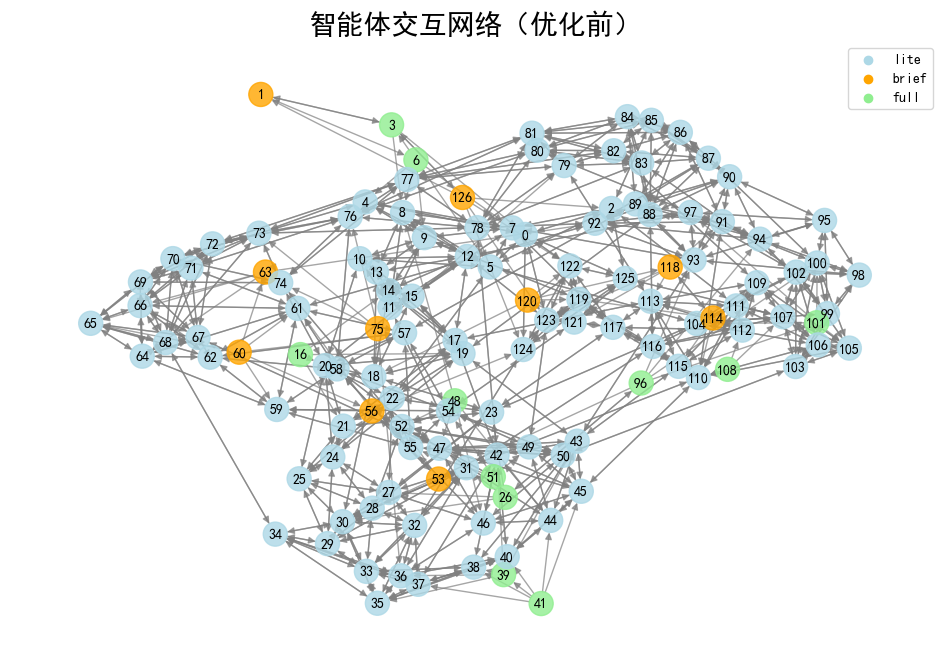

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 3. 构建交互网络图
G = nx.DiGraph()

for agent_id, agent_type in agent_type_map.items():
    G.add_node(agent_id, agent_type=agent_type)

for inter in interactions:
    G.add_edge(inter['source'], inter['target'], interaction=inter['type'], attitude=inter['attitude'])


print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# 4. 绘制交互网络图（区分节点类型和交互类型）
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.3, iterations=50)

node_colors = {'lite': 'lightblue', 'brief': 'orange', 'full': 'lightgreen'}
node_color_list = [node_colors.get(G.nodes[node]['agent_type'], 'gray') for node in G.nodes]

node_colors = {'lite': 'lightblue', 'brief': 'orange', 'full': 'lightgreen'}
node_color_list = [node_colors.get(G.nodes[node]['agent_type'], 'gray') for node in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=node_color_list, node_size=300, alpha=0.8)

edge_colors = {'listen': 'gray', 'update': 'green', 'reflect': 'red'}
for interaction_type, color in edge_colors.items():
    edges_of_type = [(u, v) for u, v, d in G.edges(data=True) if d['interaction'] == interaction_type]
    nx.draw_networkx_edges(G, pos, edgelist=edges_of_type, edge_color=color, label=interaction_type, alpha=0.7)

nx.draw_networkx_labels(G, pos, font_size=10)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.title("智能体交互网络（优化前）", fontsize=20, fontweight='bold')
# plt.legend(edge_colors.keys())
# 按照agent类型绘制图例
for agent_type, color in node_colors.items():
    plt.scatter([], [], c=color, label=agent_type)
plt.axis('off')
plt.legend()
plt.savefig("优化前_agent_interaction_network.png", dpi=300, bbox_inches='tight')
plt.show()



# 态度变化趋势图

Attitude DataFrame 示例：
          0    1         2    3         4         5    6         7         8  \
0  1.122179  NaN -2.053059  NaN -0.762244  3.579375  NaN  0.087294 -0.754052   
1  7.047125  0.7 -5.165155  0.2 -1.803223       NaN  0.8 -8.378439 -0.754052   
2  9.338959  NaN -2.038128  NaN  4.682466 -9.993189  NaN  4.453121 -0.754052   
3       NaN  0.8 -4.698789  0.6       NaN       NaN  0.7       NaN -0.754052   
4       NaN  NaN  5.381976  NaN       NaN  9.955427  NaN  2.142921 -0.754052   

          9  ...       117  118       119  120       121      122       123  \
0  0.505610  ...  0.801274  NaN -1.305764  NaN  1.370115 -0.20309 -0.852803   
1  0.391097  ...  2.381308 -0.2 -3.463842  0.7  2.755771  2.28775       NaN   
2  1.267254  ...  2.246625  NaN -0.316458  NaN  0.732416      NaN  6.967935   
3  2.226112  ...  3.512134 -0.8 -2.695608  0.8 -1.460300      NaN       NaN   
4 -4.620481  ... -3.641830  NaN -7.180192  NaN -4.575671      NaN       NaN   

        124       125

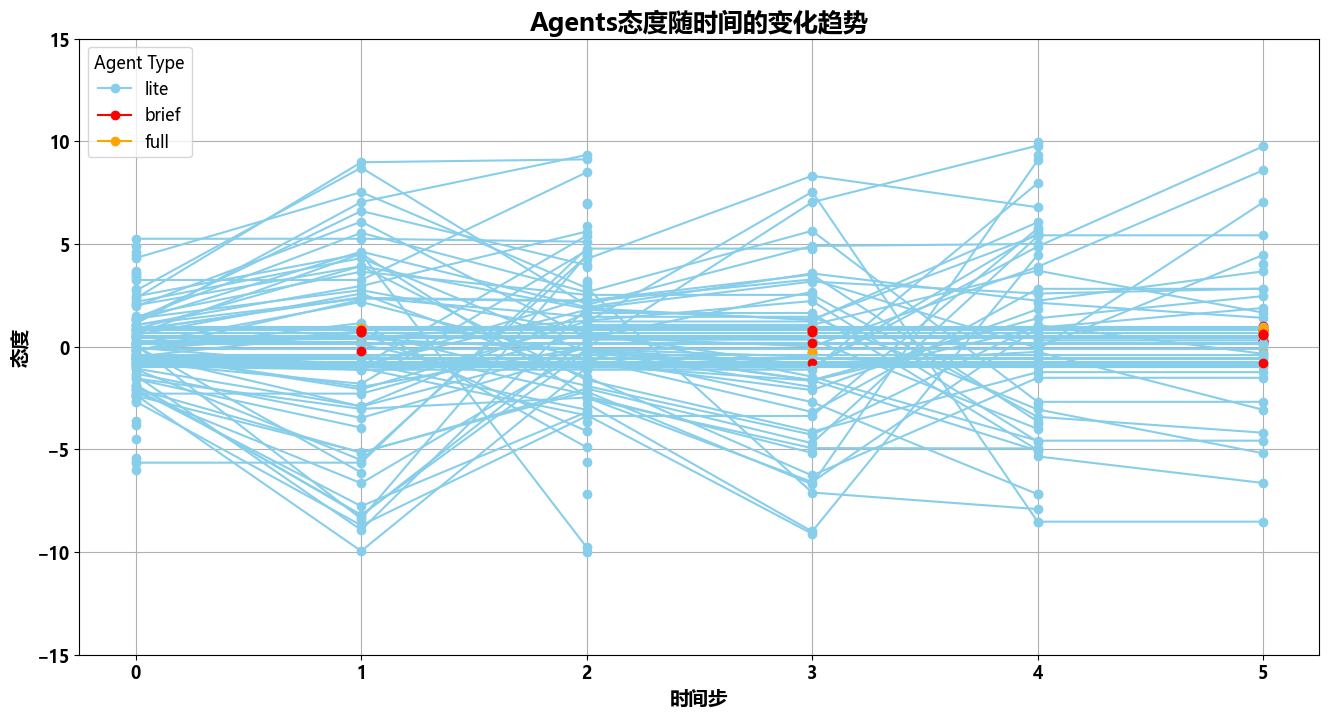

In [75]:
# 5. 态度变化趋势分析
attitude_df = pd.DataFrame(attitude_data).sort_index()

# 去除态度中绝对值大于10的异常值
attitude_df = attitude_df.applymap(lambda x: x if abs(x) <= 10 else None)

print("Attitude DataFrame 示例：")
print(attitude_df.head())

plt.figure(figsize=(16, 8))
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 定义agent类型的颜色映射，与网络图一致
agent_type_colors = {'lite': 'SkyBlue', 'brief': 'red', 'full': 'orange'}

# 遍历每个agent，按类型染色
for agent_id in attitude_df.columns:
    agent_type = agent_type_map.get(agent_id, 'unknown')
    # 只在该类型第一次出现时添加标签
    if agent_id == [a for a in attitude_df.columns if agent_type_map.get(a) == agent_type][0]:
        plt.plot(attitude_df.index, attitude_df[agent_id], color=agent_type_colors[agent_type], marker='o', label=agent_type)
    else:
        plt.plot(attitude_df.index, attitude_df[agent_id], color=agent_type_colors[agent_type], marker='o')

# 设置标签和标题
plt.xlabel("Time Step")
plt.ylabel("Attitude")
plt.title("Agents态度随时间的变化趋势", fontsize=18, fontweight='bold', color='black')
plt.ylim(-15, 15)
plt.xticks(fontsize=12, fontweight='bold', color='black')
plt.yticks(fontsize=12, fontweight='bold', color='black')
plt.xlabel("时间步", fontsize=14, fontweight='bold', color='black')
plt.ylabel("态度", fontsize=14, fontweight='bold', color='black')
# 添加图例并显示网格
plt.legend( title='Agent Type', loc='upper left', fontsize='large', title_fontsize='large')
plt.grid(True)
plt.savefig('优化后_智能体态度变化趋势.png', dpi=300, bbox_inches='tight')
plt.show()

# 保存图像


In [53]:
# {
#   "agentTypeMap": {
#     "0": "lite",
#     "1": "brief",
#     "2": "full",
#     "3": "lite"
#     // ...
#   },
#   "interactions": [
#     {
#       "source": "0",
#       "target": "1",
#       "type": "listen",
#       "attitude": -28.88,
#       "time": 0
#     },
#     // ...
#   ],
#   "attitudeData": {
#     "0": { "0": -28.88, "1": -137.09, "2": -29.17, "3": -115.15 },
#     "1": { "1": 0.0, "3": 0.0 },
#     "2": { "0": 0.92, "1": 0.92 },
#     // ...
#   }
# }


# 保存数据到 JSON 文件
output_data = {
    "agentTypeMap": agent_type_map,
    "interactions": interactions,
    "attitudeData": attitude_data
}

with open('./优化前_agent_data.json', 'w') as f:
    json.dump(output_data, f, indent=2)



# 词云图

Processing log for full agent: 101
Processing log for full agent: 108
Processing log for full agent: 16
Processing log for full agent: 26
Processing log for full agent: 3
Processing log for full agent: 39
Processing log for full agent: 41
Processing log for full agent: 48
Processing log for full agent: 51
Processing log for full agent: 6
Processing log for full agent: 96


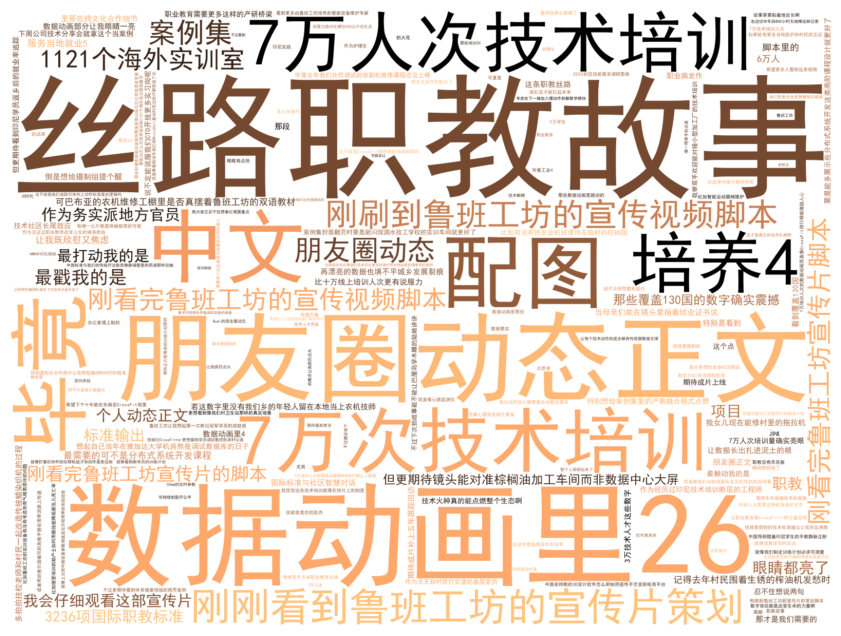

In [55]:
# %%
import os
import glob
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. 收集 full agent 的日志文本
full_agents_text = ""
# 可手动补充一些额外的无意义词（如系统常见噪音词），如果有需要的话
additional_stopwords = {
    "think", "好", "好的",
    "现在", "接下来", "可以", "已婚", "excel", "ent",
    "口语化", "情绪明确", "的学习平台", 
    "我现在需要帮助用户生成一条关于鲁班工坊项目的微博内容",
    "平均有200字以内", 
    "需要", "帮助", "一个", "进行", "以及", "然后", "如果", "已经","控制在200字以内","我现在需要帮用户生成一条关于鲁班工坊项目的微博内容","表达对鲁班工坊项目的看法","and","excellent","Budi"
}


# 遍历日志文件
for file in glob.glob('./log/experiment_test1_3_20/agent_*.json'):
    base = os.path.basename(file)  # 例如 "agent_XX.json"
    # 提取 agent_id：假设文件名格式为 agent_<ID>.json
    agent_id = base.split('_')[1].split('.')[0]
    # 检查该 agent 是否为 full 类型（agent_type_map 变量已在前面的 cell 中定义）
    if agent_type_map.get(agent_id) == "full":
        print(f"Processing log for full agent: {agent_id}")
        with open(file, 'r', encoding='utf-8') as f:
            events = json.load(f)
        for event in events:
            # 尝试直接获取日志文本
            log_content = event.get('log', '')
            # 如果没有 log 字段，尝试 item 中的 content 字段
            if not log_content:
                log_content = event.get('item', {}).get('content', '')
            if log_content:
                full_agents_text += " " + log_content

# 2. 加载停用词列表（注意：此处路径需确保在当前系统下可访问）
stopwords_path = r"D:\Research Codes\Crawl\socialnetwork\WeiboTopicRepostCrawl\hit_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as f:
    file_stopwords = {line.strip() for line in f if line.strip()}

# 合并停用词和额外无意义词
stopwords = file_stopwords.union(additional_stopwords)

# 

# 3. 生成词云
wc = WordCloud(
    font_path='simhei.ttf',   # 请确保 simhei.ttf 文件在系统可识别路径下
    background_color='white',
    stopwords=stopwords,
    colormap="copper",
    width=1600,
    height=1200,
    max_words=200,
    max_font_size=500,
)
wc.generate(full_agents_text)

# 4. 绘制词云图
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.title("Full Agent模拟输出词云图（优化前）", fontsize=20, fontweight='bold', color='black')
plt.show()
# 保存词云图
wc.to_file("优化前_full_agent_词云.png")


Processing log for full agent: 101
Processing log for full agent: 108
Processing log for full agent: 16
Processing log for full agent: 26
Processing log for full agent: 3
Processing log for full agent: 39
Processing log for full agent: 41
Processing log for full agent: 48
Processing log for full agent: 51
Processing log for full agent: 6
Processing log for full agent: 96


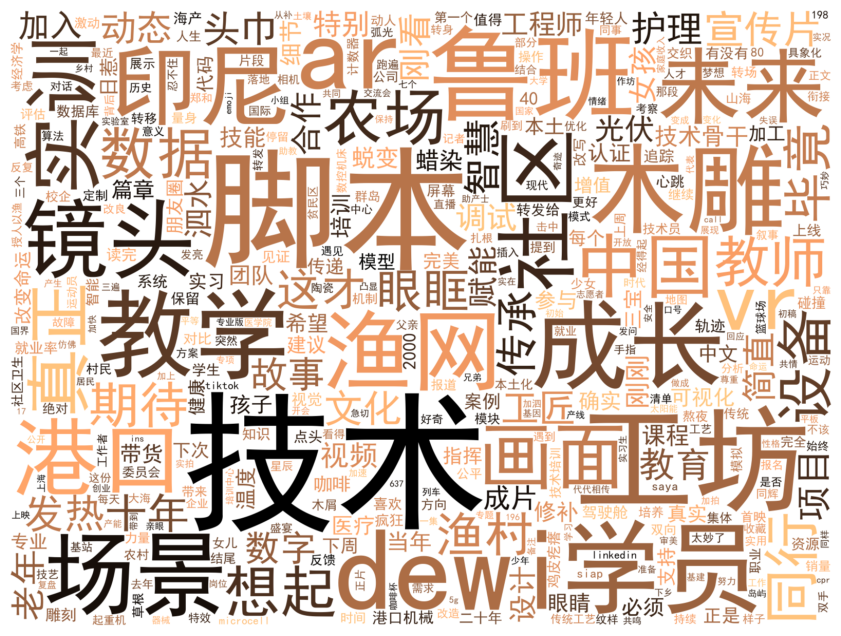

In [56]:
# %%
import os
import glob
import json
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. 收集 full agent 的日志文本
full_agents_text = ""
additional_stopwords = {
    "think", "好", "好的", "现在", "接下来", "可以", "已婚", "excel", "ent",
    "口语化", "情绪明确", "的学习平台", "我现在需要帮助用户生成一条关于鲁班工坊项目的微博内容",
    "平均有200字以内", "需要", "帮助", "一个", "进行", "以及", "然后", "如果", "已经",
    "控制在200字以内", "我现在需要帮用户生成一条关于鲁班工坊项目的微博内容", 
    "表达对鲁班工坊项目的看法", "and", "excellent", "Budi"
}

for file in glob.glob('./log/experiment_test1_3_19/agent_*.json'):
    base = os.path.basename(file)
    agent_id = base.split('_')[1].split('.')[0]
    if agent_type_map.get(agent_id) == "full":  # 假设 agent_type_map 已定义
        print(f"Processing log for full agent: {agent_id}")
        with open(file, 'r', encoding='utf-8') as f:
            events = json.load(f)
        for event in events:
            log_content = event.get('log', '') or event.get('item', {}).get('content', '')
            if log_content:
                full_agents_text += " " + log_content

# 2. 加载停用词并进行文本预处理
stopwords_path = r"D:\Research Codes\Crawl\socialnetwork\WeiboTopicRepostCrawl\hit_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as f:
    file_stopwords = {line.strip() for line in f if line.strip()}
stopwords = file_stopwords.union(additional_stopwords)

# 分词并清洗
words = jieba.lcut(full_agents_text)
cleaned_words = [word for word in words if word not in stopwords and len(word) > 1]

# 3. TF-IDF 计算
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([' '.join(cleaned_words)])
feature_names = vectorizer.get_feature_names_out()
tfidf_dict = dict(zip(feature_names, tfidf_matrix.toarray()[0]))

# 4. 生成词云
wc = WordCloud(
    font_path='simhei.ttf',  # 确保字体文件路径正确
    background_color='white',
    stopwords=stopwords,
    colormap="copper",
    width=1600,
    height=1200,
    max_words=400,
    max_font_size=300,
)
wc.generate_from_frequencies(tfidf_dict)  # 使用TF-IDF权重

# 5. 绘制和保存词云
plt.figure(figsize=(20, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.title("Full Agent模拟输出词云图（TF-IDF）", fontsize=24, fontweight='bold', color='black')
plt.show()
wc.to_file("优化前_full_agent_词云_TFIDF.png")

# 态度对比趋势图

实验1(3_19) 交互记录数: 2764
实验2(3_20) 交互记录数: 2774
实验1 df_19:
           0    1        10       100  101       102       103       104  \
0  1.122179  NaN  0.850278  2.180420  NaN -0.599284 -1.547318  0.971166   
1  7.047125  0.7  0.850278  4.317671  0.8 -0.599284 -3.028224  0.971166   
2  9.338959  NaN  0.850278 -0.258331  NaN -0.599284 -2.474320  0.971166   
3       NaN  0.8  0.850278 -0.960326  0.9 -0.599284 -6.589844  0.971166   
4       NaN  NaN  0.850278  4.876766  NaN -0.599284  0.920849  0.971166   

        105       106  ...        90        91        92        93        94  \
0  0.043170 -0.154008  ... -0.852023 -1.097257 -0.844744  0.122958 -0.149083   
1 -6.128116  0.751931  ... -0.852023 -5.521376 -0.844744  0.122958  1.151178   
2       NaN -1.912680  ... -0.852023  4.414648 -0.844744  0.122958 -4.898620   
3       NaN -4.285766  ... -0.852023       NaN -0.844744  0.122958       NaN   
4  0.912060  1.050094  ... -0.852023 -7.180519 -0.844744  0.122958       NaN   

         95 

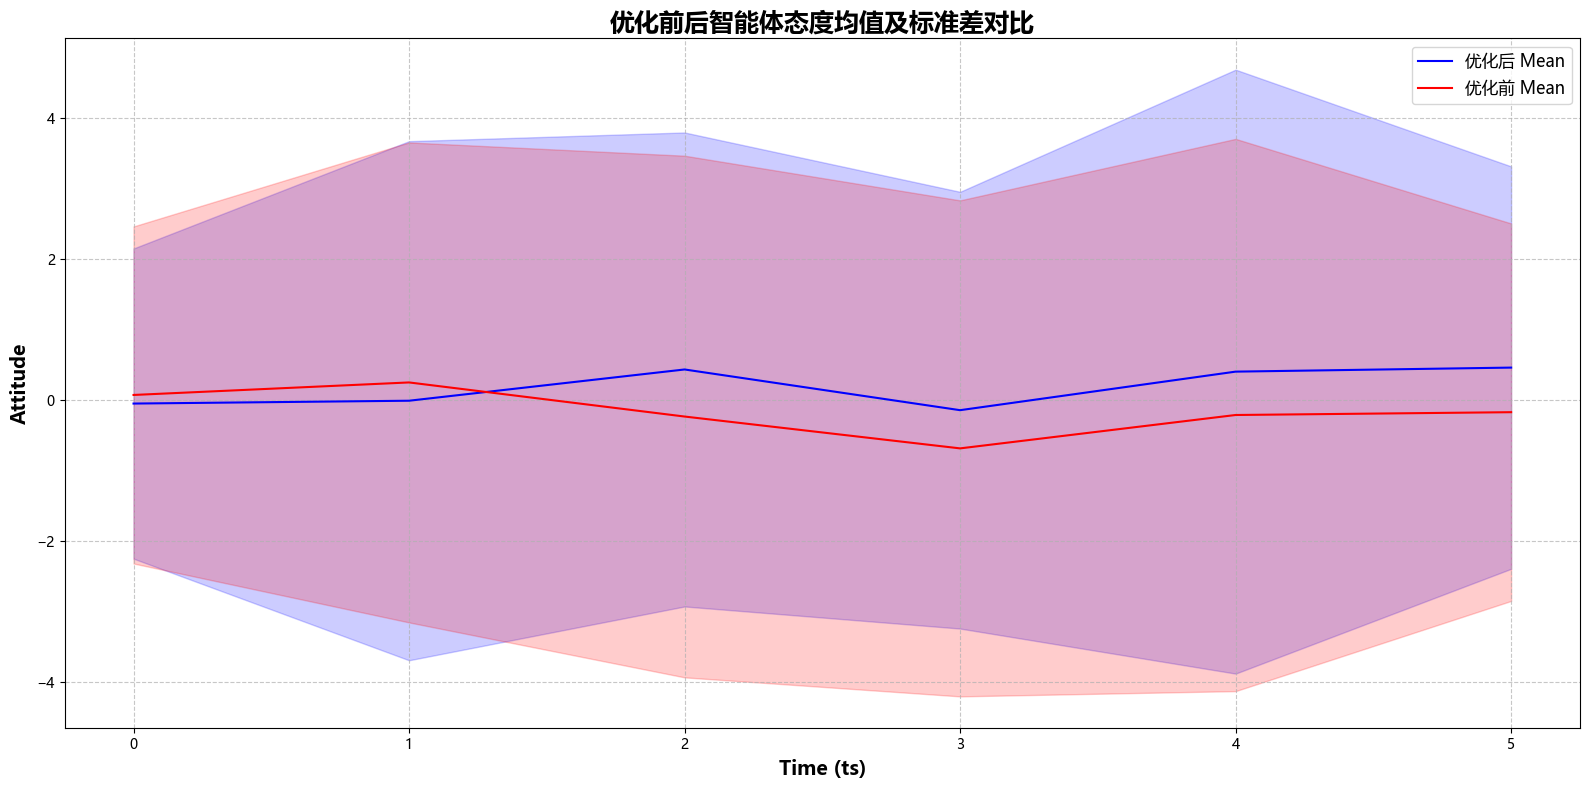

In [65]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

########################################
# A: 已有的 agent_type_map 载入，这里示例用伪字典
########################################
# 假设您在前面已有对 Combined_Personas.json 的加载代码
# 这里简单示例一个 agent_type_map


########################################
# B: 定义读取实验日志的函数
########################################
def read_experiment_logs(experiment_path):
    """
    从指定目录下加载 agent_*.json 日志，解析出 interactions 和 attitude_data.
    返回 (interactions, attitude_data)
    """
    interactions = []
    attitude_data = {}
    for aid in agent_type_map.keys():
        attitude_data[aid] = {}
    seen_events = set()

    # glob 匹配所有 agent_*.json 文件
    file_pattern = os.path.join(experiment_path, "agent_*.json")
    for file in glob.glob(file_pattern):
        base_name = os.path.basename(file)  # agent_<ID>.json
        agent_id = base_name.split('.')[0].split('_')[1]

        with open(file, 'r', encoding='utf-8') as f:
            events = json.load(f)
        
        for event in events:
            ts = event.get('ts')
            event_type = event.get('type')
            item = event.get('item', {})
            
            # 如果存在 source 和 attitude，则为一次交互
            src = item.get('source')
            tgt = agent_id
            att = item.get('attitude')

            # 交互记录
            if src is not None and event_type in ["listen", "talk_content"]:
                event_key = (ts, str(src), tgt, event_type)
                if event_key not in seen_events:
                    interactions.append({
                        'source': str(src),
                        'target': tgt,
                        'type': event_type,
                        'attitude': att,
                        'time': ts
                    })
                    seen_events.add(event_key)

            # 如果是 update / reflect / vote，则记录态度变化
            if event_type in ['update', 'reflect', 'vote']:
                new_attitude = item.get('new_attitude') or att
                if new_attitude is not None:
                    # 记录到 attitude_data 中
                    attitude_data[tgt][ts] = new_attitude

    # 按时间排序 attitude_data, 并返回
    return interactions, attitude_data

########################################
# C: 分别加载两个实验的数据
########################################
interactions_18, attitude_data_18 = read_experiment_logs("./log/experiment_test1_3_19")
interactions_19, attitude_data_19 = read_experiment_logs("./log/experiment_test1_3_20")

print("实验1(3_19) 交互记录数:", len(interactions_18))
print("实验2(3_20) 交互记录数:", len(interactions_19))

########################################
# 将 attitude_data 转为 DataFrame 或 numpy array
# 让行索引为时间 ts，列索引为 agent_id
########################################
def attitude_data_to_dataframe(attitude_data_dict):
    # 收集所有时间点
    all_ts = set()
    for aid, ts_dict in attitude_data_dict.items():
        all_ts.update(ts_dict.keys())
    # 统一排序
    sorted_ts = sorted(all_ts)

    # 构造 DataFrame 行为时间，列为 agent
    df = pd.DataFrame(index=sorted_ts, columns=sorted(agent_type_map.keys()), dtype=float)

    # 逐个填充
    for aid, ts_dict in attitude_data_dict.items():
        for ts, val in ts_dict.items():
            df.loc[ts, aid] = val

    # 可能有的ts没有记录，为NaN
    df = df.sort_index()
    return df

df_18 = attitude_data_to_dataframe(attitude_data_18)
df_19 = attitude_data_to_dataframe(attitude_data_19)

# 去除态度中绝对值大于 2 的异常值
df_18 = df_18.mask(df_18.abs() > 10)
df_19 = df_19.mask(df_19.abs() > 10)

# 打印观察
print("实验1 df_19:\n", df_18.head())
print("实验2 df_20:\n", df_19.head())

########################################
# D: 绘制【整体态度趋势对比图】(均值±标准差)
########################################

def plot_experiment_mean_std(df_exp1, df_exp2, exp1_label="优化后", exp2_label="优化前"):
    """
    在同一张图中绘制两次实验的整体态度均值和标准差对比。
    df_exp1, df_exp2: index为时间ts, columns为agent ID的DataFrame, 存储态度值
    """
    # 先将DataFrame中的每行(某个ts)的所有agent态度值做均值、std
    # 注意要排除NaN
    mean_1 = df_exp1.mean(axis=1, skipna=True)
    std_1  = df_exp1.std(axis=1, skipna=True)
    mean_2 = df_exp2.mean(axis=1, skipna=True)
    std_2  = df_exp2.std(axis=1, skipna=True)

    # X 轴是时间序列
    t1 = mean_1.index
    t2 = mean_2.index

    plt.figure(figsize=(16,8))

    # 绘制实验1
    plt.plot(t1, mean_1, color='blue', label=f'{exp1_label} Mean')
    plt.fill_between(t1, mean_1 - std_1, mean_1 + std_1, color='blue', alpha=0.2)

    # 绘制实验2
    plt.plot(t2, mean_2, color='red', label=f'{exp2_label} Mean')
    plt.fill_between(t2, mean_2 - std_2, mean_2 + std_2, color='red', alpha=0.2)

    plt.xlabel('Time (ts)', fontsize=14, fontweight='bold', color='black')
    plt.ylabel('Attitude', fontsize=14, fontweight='bold', color='black')
    plt.title('优化前后智能体态度均值及标准差对比', fontsize=18, fontweight='bold', color='black')
    plt.legend(loc='best', fontsize='large', title_fontsize='large')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("优化前后态度均值及标准差对比.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_experiment_mean_std(df_18, df_19)

# ########################################
# # E: 绘制【态度净变化幅度】(柱状图)
# ########################################

# def plot_attitude_amplitude_compare(df_exp1, df_exp2, exp1_label="优化后", exp2_label="优化前"):
#     """
#     计算每个代理在两个实验里初始与最终态度值(非空时刻)差的绝对值对比，并以柱状图展示。
#     df_exp1, df_exp2: index=时间ts, columns=agent ID
#     """
#     agent_ids = sorted(agent_type_map.keys())

#     amplitude_1 = []
#     amplitude_2 = []

#     for aid in agent_ids:
#         # 在 df_exp1 中获取该agent有效态度
#         series1 = df_exp1[aid].dropna()
#         if len(series1) > 0:
#             # 初始态度、最终态度
#             val_init_1 = series1.iloc[0]
#             val_final_1 = series1.iloc[-1]
#             amp1 = abs(val_final_1 - val_init_1)
#         else:
#             amp1 = np.nan

#         # 在 df_exp2 中获取该agent有效态度
#         series2 = df_exp2[aid].dropna()
#         if len(series2) > 0:
#             val_init_2 = series2.iloc[0]
#             val_final_2 = series2.iloc[-1]
#             amp2 = abs(val_final_2 - val_init_2)
#         else:
#             amp2 = np.nan

#         amplitude_1.append(amp1)
#         amplitude_2.append(amp2)

#     # 绘制柱状图
#     x = np.arange(len(agent_ids))
#     width = 0.3

#     plt.figure(figsize=(16,8))
#     plt.bar(x - width/2, amplitude_1, width, label=exp1_label, color='orange')
#     plt.bar(x + width/2, amplitude_2, width, label=exp2_label, color='darkred')

#     plt.xticks(x, agent_ids)
#     plt.ylabel('Attitude Change Amplitude')
#     plt.title('优化前后智能体态度演变情况对比', fontsize=18, fontweight='bold', color='black')
#     plt.legend()
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

# plot_attitude_amplitude_compare(df_18, df_19)


# 内容意见总结

In [15]:
import json
import glob
# from casevo import LLM_INTERFACE
from model_client import ModelClient
import os

# 配置 API 和模型参数
API_KEY = 'aac7e5f2-63f9-410c-98b5-51a60ac1a8c3'  # 请替换为你的实际 API_KEY
CHAT_MODEL = "deepseek-r1-250120"     # 可根据需要调整模型

# APIChatClient 类，用于调用模型生成文本
class APIChatClient:
    def __init__(self, model, api_key):
        self.client = ModelClient(model=model, api_key=api_key)
    
    def complete(self, prompt):
        class Response:
            def __init__(self, text):
                self.text = text
        return Response(self.client.generate(prompt))



# 初始化 OllamaLLM
llm = APIChatClient(CHAT_MODEL, API_KEY)

# 第一步：遍历每个 agent 的 log 并生成总结
agent_summaries = []
for file in glob.glob('./log/experiment_test1_3_20/agent_*.json'):
    
    
    base = os.path.basename(file)
    agent_id = base.split('_')[1].split('.')[0]
    # 如果agent类型为full或brief，才进行分析
    if agent_type_map.get(agent_id) not in ["full", "brief"]:
        continue
    print(f"Processing log for agent: {agent_id}")
    with open(file, 'r', encoding='utf-8') as f:
        events = json.load(f)
    agent_logs = []
    for event in events:
        log_content = event.get('log', '') or event.get('item', {}).get('content', '')
        if log_content:
            agent_logs.append(log_content)
    agent_text = "\n".join(agent_logs)

    # 设计先进的 prompt，使用 COT 思路生成单个 agent 的总结
    prompt_single = f"""
你是一位顶尖的内容分析师，擅长从复杂的文本中提取关键信息。你的任务是分析以下 agent 的日志，总结其对宣传片的评价，包括优点、缺点和建议。请按照以下步骤逐步推理，并输出结构化的结果：

1. **阅读并理解**：仔细阅读日志内容，识别 agent 对宣传片的看法。
2. **提取关键点**：找出所有关于优点、缺点和建议的描述。
3. **归纳总结**：将零散的信息整理为简洁的要点，确保不遗漏重要内容。
4. **格式化输出**：按照以下格式输出总结，保持简明扼要。

**输出格式**：
```
**优点**：
- [优点1]
- [优点2]

**缺点**：
- [缺点1]
- [缺点2]

**建议**：
- [建议1]
- [建议2]
```

以下是 agent 的日志内容：
{agent_text}
"""
    summary = llm.complete(prompt_single).text
    agent_summaries.append(summary)

# 第二步：对所有 agent 的总结进行综合分析
combined_summaries = "\n\n".join(agent_summaries)

# 设计先进的 prompt，使用 COT 思路生成最终总结
prompt_combined = f"""
你是一位顶尖的战略分析师，擅长从多源数据中提炼核心洞见。你的任务是综合多个 agent 对宣传片的评价，生成一个精炼的最终总结，只保留最重要、最一致的内容。请按照以下步骤逐步推理，并输出结构化的结果：

1. **整体审视**：阅读所有 agent 的总结，理解总体趋势和分歧。
2. **识别共性**：找出在多个总结中反复出现的优点、缺点和建议。
3. **筛选关键点**：选择最具代表性和影响力的内容，剔除次要或不一致的细节。
4. **精炼总结**：将筛选后的内容整理为简洁有力的要点。
5. **格式化输出**：按照以下格式输出最终总结，确保简明且聚焦核心。

**输出格式**：
```
**核心优点**：
- [优点1]
- [优点2]

**核心缺点**：
- [缺点1]
- [缺点2]

**核心建议**：
- [建议1]
- [建议2]
```

以下是多个 agent 的总结：
{combined_summaries}
"""
final_analysis = llm.complete(prompt_combined).text

# 将最终分析结果保存到 .md 文件
with open('old_content_analysis.md', 'w', encoding='utf-8') as f:
    f.write(final_analysis)

print("最终分析结果已保存到 final_analysis.md 文件中")

Processing log for agent: 1
Processing log for agent: 101
Processing log for agent: 108
Processing log for agent: 114
Processing log for agent: 118
Processing log for agent: 120
Processing log for agent: 126
Processing log for agent: 16
Processing log for agent: 26
Processing log for agent: 3
Processing log for agent: 39
Processing log for agent: 41
Processing log for agent: 48
Processing log for agent: 51
Processing log for agent: 53
Processing log for agent: 56
Processing log for agent: 6
Processing log for agent: 60
Processing log for agent: 63
Processing log for agent: 75
Processing log for agent: 96
最终分析结果已保存到 final_analysis.md 文件中


In [12]:
import imageio
import glob
import os

def jpgs_to_gif(jpg_files, output_gif, fps=1):
    """
    将一系列JPG图片转换为GIF。
    
    参数:
    jpg_files (list): JPG文件路径列表。
    output_gif (str): 输出GIF文件名。
    fps (int): 帧率，每秒帧数。
    """
    images = []
    for jpg in jpg_files:
        images.append(imageio.imread(jpg))
    imageio.mimwrite(output_gif, images, fps=fps)

# 查找所有以“屏幕截图_20-3-2025_122118_localhost”开头的JPG文件
jpg_files = sorted(glob.glob('屏幕截图_20-3-2025_*.jpeg'))

# 指定输出GIF文件名
output_gif = 'output.gif'

# 执行转换
jpgs_to_gif(jpg_files, output_gif)

print(f"成功将JPG图片转换为GIF: {output_gif}")

C:\Users\23779\AppData\Local\Temp\ipykernel_24540\1341779032.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(jpg))


成功将JPG图片转换为GIF: output.gif
